# Collect and Analyze a Twitter Network
[Effrosyni Simou](http://lts4.epfl.ch/simou), *PhD Student*, [EPFL](http://epfl.ch) [LTS4](http://lts4.epfl.ch)

# Objective of Exercise
The aim of this exercise is to learn how to create your own, real network using data collected from the Internet and then to discover some properties of the collected network. 

# Resources
You might want to have a look at the following resources before starting:

* [Twitter REST API](https://dev.twitter.com/rest/public)
* [Tweepy Documentation](http://tweepy.readthedocs.io/en/v3.5.0/)
* [Tutorial "Mining Twitter data with Python"](https://marcobonzanini.com/2015/03/02/mining-twitter-data-with-python-part-1/)

# 1. Collect a Twitter Network

In order to collect data from Twitter you will need to generate access tokens.  To do this you will need to register a [client application with Twitter](https://apps.twitter.com/). Once you are done you should have your tokens. You can now create a `credentials.ini` file as follows:
```
[twitter]
consumer_key = UtjS4wwl383CF07iggsEqJ3vL
consumer_secret = BrC1j0bNO0hhN3yArXG4W67TAxx4R8xr2Mjai05oysBy3TMGNu
access_token = BrC1j0bNO0hhN3yArXG4W67TAxx4R8xr2Mjai05oysBy3TMGNu
access_secret = 9nbckr6pwriVfphBZ8KbNCzCkY4BHECqrjtPV6mhWTCgx
```
In this way you will have this information readily available to you. 

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import random
import configparser
import tweepy

from pprint import pprint

In [2]:
consumer_key = "UtjS4wwl383CF07iggsEqJ3vL"
consumer_secret = "BrC1j0bNO0hhN3yArXG4W67TAxx4R8xr2Mjai05oysBy3TMGNu"
access_token = "457830564-AFxKJrAzg1v9u7BPxkrEoWRB49LBDSXXtD3biH2Y"
access_secret = "9nbckr6pwriVfphBZ8KbNCzCkY4BHECqrjtPV6mhWTCgx"

In [3]:
#authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

#construct API instance
#deal with rate limits and notify when delayed because of rate limits
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

Now you are all set up to start collecting data from Twitter! 

In this exercise we will construct a network with the following logic:

1) We will chose a `user_id` in Twitter to be our first node. 

2) We will find (some) of the users who are both following `user_id` and are being followed by `user_id`. From now on we will call such users "connections" of `user_id`. We will place these user ids in a list called `first_nodes`. 

3) For every node in the list `first_nodes` we will then find (some) of the users who are following and are being followed by this node (aka the connections of this node). The user ids collected in this step will be placed in a list called `second_nodes`.

4) The collection of the ids of all nodes (aka Twitter users) that we have collected so far will be placed in a list called `all_nodes`.

5) Since we have only collected a subset of all possible "connections" for our nodes we have to check if there are any remaining inner connections that we have missed.

The entire network is to be organized in a dictionary with entries that will have as key the Twitter id of the user (this is a number characterizing each user in Twitter) and as value the list of ids of his connections.

So, let us begin. The first thing that you will have to do is to chose the node from which everything will start. I have chosen the Twitter account of [Applied Machine Learning Days](https://www.appliedmldays.org) that will take place in January 2018 in EPFL. You may change that if you wish to, but please make sure that the user you chose has both followers and friends and that he allows you to access this data.

In [ ]:
user = 'appliedmldays'
user_id = api.get_user(user).id

In [ ]:
restricted_user = "dusanvic"
restricted_user_id = api.get_user(restricted_user).id

In the following cell write a function that takes as an argument the Twitter id of a user and returns a list with the **ids** of his connections. Take into account the case where a user does not allow you to access this information.

**Reminder:** By connections we mean users that are both followers and friends of a given user.

In [6]:
def get_friends_ids(user_id):
    try:
        return api.friends_ids(user_id)
    except:
        return []

In [7]:
def get_followers_ids(user_id):
    try:
        return api.followers_ids(user_id)
    except:
        return []

In [8]:
def find_connections(user_id):
    followers = get_followers_ids(user_id)
    friends= get_friends_ids(user_id)
    return set(followers) & set(friends)

In [9]:
connections = find_connections(user_id)

In [10]:
print('{}has {} connections'.format(user, len(connections)))

appliedmldays has 139 connections


In [11]:
connections_from_restricted = find_connections(restricted_user_id)

In [12]:
print('{}has {} connections'.format(restricted_user, len(connections_from_restricted)))

dusanvichas 0 connections


Collect your `first_nodes` and `second_nodes` and organize your collected nodes and their connections in the dictionary called `network`.

Hints:
* Use `random.choice([1,3,4])` to randomly choose a number in `[1, 3, 4]`.
* Use the `append` and `remove` methods to add and remove an element from a Python list.
* The `pop` method removes the last item in the list.

In [15]:
# helper function
def flatten_list_of_nodes(ls):
    all_nodes = set()
    for nodes in ls:
        all_nodes = all_nodes | nodes
    return all_nodes

In [62]:
# test
flatten_list_of_nodes([set([1,2]), set([3,1,2]), set([1,4])])

{1, 2, 3, 4}

In [13]:
def get_sample_connections(node, sample_size):
    connections = find_connections(node)
    if len(connections) < sample_size:
        return connections
    else:
        return set(random.sample(connections, sample_size))

In [14]:
def get_sampled_network(nodes, sample_size):
    network = {}
    for node in nodes:
        network[node] = get_sample_connections(node, sample_size)
    return network

In [17]:
def build_network(user_id, depth=2, sample_size=3):
    network = {}
    
    root_nodes = set([user_id])
    nodes_by_depth = [root_nodes]

    for i in range(depth):
        net = get_sampled_network(nodes_by_depth[i], sample_size)
        nodes_discovered = flatten_list_of_nodes(net.values())
        
        nodes_by_depth.append(nodes_discovered)
        network.update(net)
        
    return network, nodes_by_depth

In [18]:
# /!\ TAKE LONG TIME TO RUN /!\

how_many = 10

network, nodes_by_depth = build_network(user_id, sample_size=how_many)

Rate limit reached. Sleeping for: 390


**Be careful!** You should only keep a small value for the `how_many` parameter while you are developing your code. In order to answer to the questions you should raise the value of this parameter to `how_many=10` at least. This will take a while to execute because of the API rate limit (plan your time accordingly). You should also remember to submit your jupyter notebook with the **output shown for a large value of the `how_many` parameter**. 

In [19]:
pprint(network)

{54628799: {26789088,
            188525525,
            224972663,
            244413242,
            248475557,
            330912841,
            814794756,
            1136638363,
            2290301735,
            2583761190},
 83657910: {9289822,
            10359582,
            14359848,
            15902496,
            22262065,
            37049955,
            40453522,
            391689867,
            610392096,
            806686735},
 120045484: {27472675,
             75821450,
             135855738,
             139372482,
             340369783,
             1295382612,
             1586105028,
             1883512009,
             2786221026,
             705105156837216256},
 335986035: {35453305,
             40938611,
             45345177,
             187666854,
             1148029304,
             1276002666,
             2670651013,
             3036329200,
             729562079108046848,
             758066723710988288},
 409757112: {30633457,
         

In [20]:
pprint(nodes_by_depth)

[{763052115392593920},
 {54628799,
  83657910,
  120045484,
  335986035,
  409757112,
  2290986096,
  774182650701418496,
  779056440380100613,
  854226651944824832,
  869090336668237824},
 {710013,
  1583811,
  9289822,
  10359582,
  14048130,
  14359848,
  15902496,
  15966654,
  20437894,
  22262065,
  26789088,
  27472675,
  30633457,
  35453305,
  37049955,
  39351968,
  40453522,
  40938611,
  44421054,
  45345177,
  55708829,
  75821450,
  113907485,
  116787878,
  126404603,
  135855738,
  139372482,
  144789234,
  156239854,
  161443532,
  162644488,
  164181335,
  187666854,
  188525525,
  224972663,
  242844365,
  244413242,
  248475557,
  260656385,
  271451861,
  306847234,
  312202153,
  330912841,
  340369783,
  382413245,
  391689867,
  437125458,
  456972548,
  570765306,
  610392096,
  632482420,
  806686735,
  814794756,
  922801934,
  1000672386,
  1012724688,
  1073157144,
  1136638363,
  1148029304,
  1244114060,
  1276002666,
  1295382612,
  1416768312,
  1586105

In [21]:
root_nodes = nodes_by_depth[0]

In [22]:
first_nodes = nodes_by_depth[1]

In [23]:
second_nodes = nodes_by_depth[2]

In [24]:
all_nodes = flatten_list_of_nodes(nodes_by_depth)

In [25]:
print('There are {} root nodes'.format(len(root_nodes)))
print('There are {} first hop nodes'.format(len(first_nodes)))
print('There are {} second hop nodes'.format(len(second_nodes)))
print('There are overall {} nodes in the collected network'.format(len(all_nodes)))

There are 1 root nodes
There are 10 first hop nodes
There are 94 second hop nodes
There are overall 103 nodes in the collected network


Find the inner connections between your collected nodes that you might have missed because you sampled the connections.

In [64]:
def find_inner_connections(node, inner_nodes):
    connections = find_connections(node)
    return connections & inner_nodes

In [65]:
def find_inner_connections(nodes):
    inner_connections = {}
    for node in nodes:
        inner_connections[node] = find_inner_connections(node, nodes - set([node]))
    return inner_connections

In [55]:
# /!\ TAKE LONG TIME TIME TO RUN /!\
full_network = find_inner_connections(all_nodes)

In [177]:
full_network

{710013: set(),
 1583811: set(),
 9289822: set(),
 10359582: set(),
 14048130: set(),
 14359848: set(),
 15902496: set(),
 15966654: set(),
 20437894: set(),
 22262065: set(),
 26789088: set(),
 27472675: set(),
 30633457: set(),
 35453305: set(),
 37049955: set(),
 39351968: set(),
 40453522: set(),
 40938611: set(),
 44421054: set(),
 45345177: set(),
 54628799: set(),
 55708829: set(),
 75821450: set(),
 83657910: set(),
 113907485: set(),
 116787878: set(),
 120045484: set(),
 126404603: set(),
 135855738: set(),
 139372482: set(),
 144789234: set(),
 156239854: set(),
 161443532: set(),
 162644488: set(),
 164181335: set(),
 187666854: set(),
 188525525: set(),
 224972663: set(),
 242844365: set(),
 244413242: set(),
 248475557: set(),
 260656385: set(),
 271451861: set(),
 306847234: set(),
 312202153: set(),
 330912841: set(),
 335986035: set(),
 340369783: set(),
 382413245: set(),
 391689867: set(),
 409757112: set(),
 437125458: set(),
 456972548: set(),
 570765306: set(),
 6

# 2. Discover some of the properties of the collected network

## 2.1 Adjacency matrix

Congradulations! You have now created a dictionary that describes a real Twitter network!
We now want to transform this dictionary into the adjacency (or weight) matrix that you learned about in your first class. 

In [68]:
W_not_sym = np.zeros([len(all_nodes),len(all_nodes)], dtype=int)

In [69]:
all_nodes_list = list(all_nodes)

In [70]:
for y in range(len(all_nodes)):
    y_node = all_nodes_list[y]
    for x in range(len(all_nodes)):
        x_node = all_nodes_list[x]
        if y_node in network[x_node]:
            W_not_sym[x, y] = 1
        else:
            W_not_sym[x, y] = 0
        

Remember that a weight matrix should be symmetric. Check if it is:

In [71]:
np.nonzero(W_not_sym - W_not_sym.T)

(array([ 0,  1,  1,  1,  3,  5, 25, 25, 35, 39, 39, 46, 47, 59, 62, 64, 70,
        70, 74, 76, 76, 83, 85, 86, 87, 87, 87, 88, 89, 91, 91, 94, 95, 96], dtype=int64),
 array([87, 39, 89, 95, 87, 85, 62, 70, 76,  1, 94, 64, 91, 86, 25, 46, 25,
        76, 83, 35, 70, 74,  5, 59,  0,  3, 88, 87,  1, 47, 96, 39,  1, 91], dtype=int64))

**Question 1:**
It might happen that $W \neq W^{T} $ for some $(i,j)$. Explain why this might be the case.

**Your answer here:**

Because some users doesn't share their followers/friends publicly.

If we know x has a connection with y, as it is bidirectionnal, we know y has a connection with x as well even though we can't query his followers/friends

Impose your weight matrix to be symmetric.

In [72]:
# Make W is symmetric
bigger = W_not_sym.transpose() > W_not_sym

In [73]:
W = W_not_sym - W_not_sym*bigger + W_not_sym.transpose()*bigger

Plot the weight matrix of your collected network.

Hint: use `plt.spy()` to visualize a matrix.

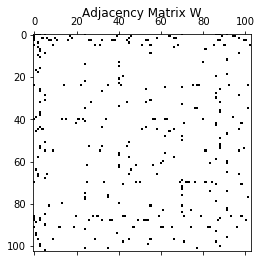

In [76]:
# your code here
plt.title('Adjacency Matrix W')
plt.spy(W)

**Question 2:**
What is the maximum number of links $L_{max}$ in a network with $N$ nodes (where $N$ is the number of nodes in your collected network)? How many links $L$ are there in your collected network? Comment on how $L$ and $L_{max}$ compare.

**Your answer here:**

In [182]:
def N(how_many):
    return 1 + how_many + how_many**2 

In [183]:
def L_max(N):
    return N * (N-1) / 2

In [188]:
def L(adjacency_matrix):
    return adjacency_matrix.sum() / 2

In [189]:
N(how_many)

111

In [190]:
L_max(N(how_many))

6105.0

In [ ]:
L(W)

As one can see, $L$ is clearly smaller than $L_{max}$. In other words, our network is sparse.

As we have seen in class, this makes sense because most real-world networks (like Facebook) are sparse.

## 2.2 Degrees distribution

Plot a histogram of the degree distribution. 

In [275]:
p = W.sum(axis=0)

In [276]:
p

array([11,  8, 10, 17,  2, 10,  2,  2,  1,  3,  1,  1,  1,  2,  1,  1,  1,
        1,  1,  1,  2,  1,  1,  1, 10,  2,  3,  2,  1,  2,  1,  2,  5,  1,
        1,  4,  1,  2,  1,  2, 11,  1,  4,  1,  3,  6,  2,  1,  2,  1,  1,
        2,  1,  5,  3,  5,  2,  1,  3,  1,  2,  3,  4,  1,  2,  1,  5,  1,
        1,  1, 11,  3,  1,  1,  2,  1,  2,  3,  1,  1,  2,  3,  1,  3,  1,
        1, 11,  3, 12,  1,  1, 11,  1,  1,  2,  1,  1,  6,  3,  2,  2,  3,
        1])

In [277]:
p.min()

1

In [278]:
p.max()

17

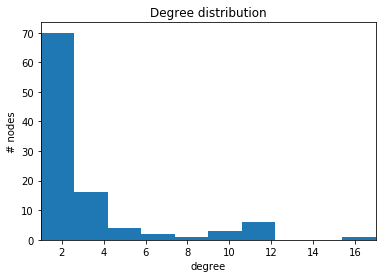

In [293]:
plt.hist(p)

plt.title("Degree distribution")
plt.xlabel("degree")
plt.ylabel("# nodes")

plt.xlim(p.min(), p.max())

plt.show()

**Question 3:** Comment on the plot. What do you observe? Would you expect a similar degree disribution in the complete Twitter network?

**Your answer here:**

## 2.3 Average degree

Calculate the average degree of your collected network.

In [238]:
d_avg = p.sum() / len(p)

In [239]:
d_avg

2.8932038834951457

## 2.4 Diameter of the collected network

**Question 4:** What is the diameter of the collected network? Please justify.

**Your answer here:**

As all nodes are at most two edges far from the root node (user_id), the maximum distance between two nodes could be at most twice as big. Hence: $4$

## 2.5 Pruning the collected network

You might notice that some nodes have very few connections and hence our matrix is very sparse. Prune the collected network so that you keep only the nodes that have a degree that is greater than the average degree and plot the new adjacency matrix.

In [268]:
mask = W.sum(axis=0) > d_avg

In [269]:
W_pruned = W[mask, :][:, mask]

In [270]:
np.nonzero(W_pruned - W_pruned.T)

(array([], dtype=int64), array([], dtype=int64))

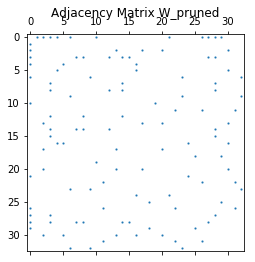

In [271]:
plt.spy(W_pruned, markersize=1)
plt.title('Adjacency Matrix W_pruned');

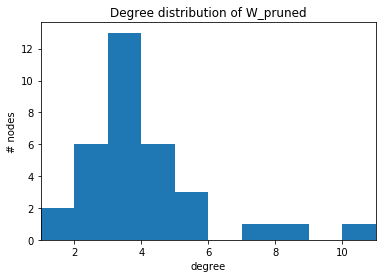

In [272]:
p_pruned = W_pruned.sum(axis=1)
plt.hist(p_pruned)

plt.title("Degree distribution of W_pruned")
plt.xlabel("degree")
plt.ylabel("# nodes")

plt.xlim(p_pruned.min(), p_pruned.max())

plt.show()

In [273]:
p.sum() / len(p)

3.5757575757575757